# Gaussian output visualized

Using one of the simulation output from 'gaussian task' (with mean temperature = 20, stdev = 10, seed = 1), this notebook shows how to generate plots similar to ones in the main result section.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
sys.path.insert(1, '../scripts/04_analytical_prediction')
from tpc_functions_oo import *
tpc_object = tpc_functions()
import tskit
from matplotlib.lines import Line2D
datadir = "../data/"
plt.rcParams.update({'font.size': 15})



MEAN_TEMP = 20
STDEV_TEMP = 10
seed = 0


## Example 1 - Plot final TPCs (Fitness vs. Temperature)
Final Bs and CTmins are saved as metadata in tree-sequence. We can sample a subset of them, color them based on whether their TPC shows any extreme adaptation.

In [29]:
ts = tskit.load(f"{datadir}gaussian_MEAN_TEMP_{MEAN_TEMP}_STDEV_TEMP_{STDEV_TEMP}_seed_{seed}.trees")
metadata = ts.metadata['SLiM']['user_metadata']
Bs_final = np.array(metadata['Bs_final'])
CTmins_final = np.array(metadata['CTmins_final'])

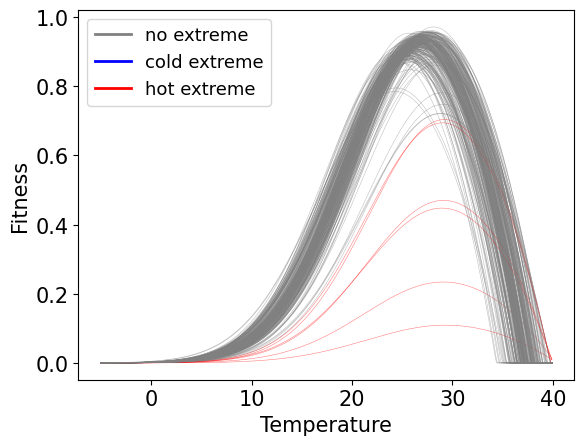

In [30]:
T_series = np.arange(-5, 40, 0.1)

sampled_Bs = []
sampled_CTmins = []
sampled_colors = []
for i, (B, CTmin) in enumerate(zip(Bs_final, CTmins_final)):
    CTmax = B + CTmin
    # Only plot 1 out of 20
    if i % 20 == 5:
        cold_extreme = (CTmin < (tpc_object.CTmin_critical + tpc_object.Delta_CTmin))
        hot_extreme = (CTmax > (tpc_object.CTmax_critical - tpc_object.Delta_CTmax))
        breadth_extreme = (B > (tpc_object.B_critical - tpc_object.Delta_B))
        if cold_extreme and not hot_extreme and not breadth_extreme:
            color = 'blue'
        elif hot_extreme and not cold_extreme and not breadth_extreme:
            color = 'red'
        elif breadth_extreme and not cold_extreme and not hot_extreme:
            color = 'green'
        elif not cold_extreme and not hot_extreme and not breadth_extreme:
            color = 'grey'
        else:
            print("extreme in two measures")
            continue
        plt.plot(T_series, tpc_object.w_TPC(CTmin=CTmin, B=B, T=T_series), 
                        linewidth=0.4, 
                        alpha=0.5, 
                        color=color)
        sampled_CTmins.append(CTmin)
        sampled_Bs.append(B)
        sampled_colors.append(color)
plt.xlabel("Temperature")
plt.ylabel("Fitness")
# Create custom legend handles
legend_handles = [
    Line2D([0], [0], color='grey', linewidth=2, label='no extreme'),
    Line2D([0], [0], color='blue', linewidth=2, label='cold extreme'),
    Line2D([0], [0], color='red', linewidth=2, label='hot extreme'),
]

# Add the legend to the figure (first subplot)
plt.legend(handles=legend_handles, fontsize=13)

## Example 2 - Plot final TPC parameters on expected fitness landscape
Same sampled TPCs are used to create scattered plot. It is overlayed on top of expected fitness landscape generated in step 4 of the workflow. 

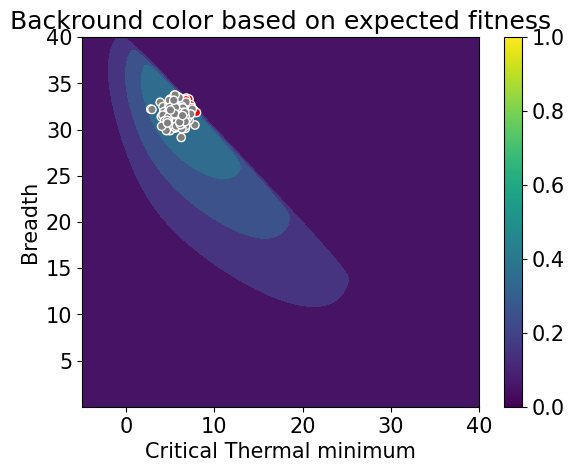

In [31]:
analytical_info = np.load(f"{datadir}gaussian_MEAN_TEMP_{MEAN_TEMP}_STDEV_TEMP_{STDEV_TEMP}_analytical_info.npz", allow_pickle=True)

plt.contourf(analytical_info['CTmin_grid'], 
                                  analytical_info['B_grid'], 
                                  analytical_info['W_contour'], 
                                  levels=np.linspace(0, 1, 11), 
                                  cmap='viridis')
plt.xlabel("Critical Thermal minimum")
plt.ylabel("Breadth")
plt.title("Backround color based on expected fitness")
plt.scatter(sampled_CTmins, sampled_Bs, marker='o', edgecolor='w', facecolor=sampled_colors)
plt.colorbar()

## Example 3 - Height vs. width of final TPCs
Negative correlation implies strong generalist-specialist tradeoff. All individuals at final generation are used.

Text(0.5, 1.0, 'Colored based on Critical Thermal maximum')

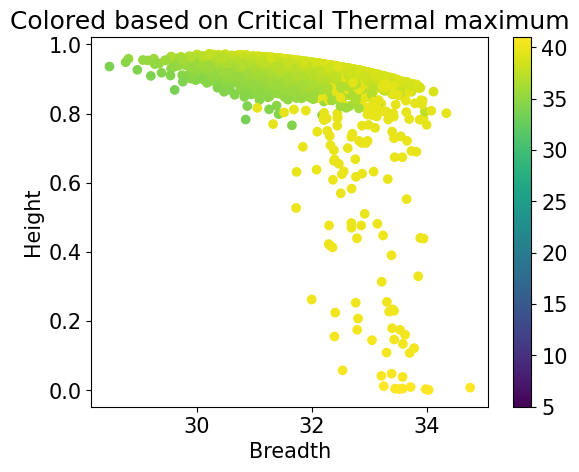

In [32]:
Topts_final = CTmins_final + Bs_final * 2/3
CTmaxs_final = CTmins_final + Bs_final
heights = [tpc_object.w_TPC(CTmin=CTmin, B=B, T=Topt) for CTmin,B,Topt in zip(CTmins_final, Bs_final, Topts_final)]

plt.scatter(Bs_final, heights, c=CTmaxs_final, cmap='viridis', vmin=5, vmax=41)
plt.colorbar()
plt.xlabel("Breadth")
plt.ylabel("Height")
plt.title("Colored based on Critical Thermal maximum")

## Example 4 - Height vs. thermal optimum
Positive correlation supports "hotter is better" hypothesis. All individuals at final generation are used.

Text(0.5, 1.0, 'Colored based on Critical Thermal maximum')

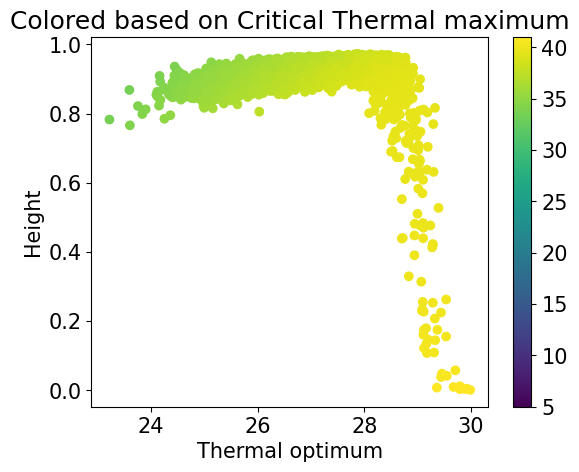

In [33]:
plt.scatter(Topts_final, heights, c=CTmaxs_final, cmap='viridis', vmin=5, vmax=41)
plt.colorbar()
plt.xlabel("Thermal optimum")
plt.ylabel("Height")
plt.title("Colored based on Critical Thermal maximum")